In [1]:
import ipyplot

import rawpy 
import cv2
import numpy as np


from skimage.exposure import match_histograms, equalize_hist
from skimage.transform import rescale

import os
import os.path as op

data_dir = op.join("..", "data")
img_name = "DSC01088"
raw_fp = op.join(data_dir, img_name+".ARW")
jpg_fp = op.join(data_dir, img_name+".JPG")

assert op.exists(raw_fp)
assert op.exists(jpg_fp)

## funcs.

In [23]:
def read_avg_green_raw(filepath):
    _img = rawpy.imread(filepath)
    img = _img.raw_image.copy()
    ih, iw, tm, lm = _img.sizes.height, _img.sizes.width, _img.sizes.top_margin, _img.sizes.left_margin
    img = np.expand_dims(img,axis=2)
    black_level = _img.black_level_per_channel[0] # assume all black level is the same
    img = (np.maximum(img - black_level, 0) + black_level)/2**16
    H = img.shape[0]
    W = img.shape[1]
    packed_img = np.concatenate((img[0:H:2, 0:W:2, :],        # R
                              img[0:H:2, 1:W:2, :],           # GR
                              img[1:H:2, 0:W:2, :],           # GB
                              img[1:H:2, 1:W:2, :]), axis=2)  # B
    greens = (packed_img[:, :, 1]+packed_img[:, :, 2]/2)/2 # RGGB
    greens = greens[tm//2:ih//2,lm//2:iw//2]
    return greens
print(read_avg_green_raw(raw_fp).shape, cv2.imread(jpg_fp).shape)

(1836, 2748) (3648, 5472, 3)


## Read and process

In [24]:
jpg = cv2.imread(jpg_fp)
jpg = cv2.cvtColor(jpg, cv2.COLOR_BGR2GRAY)
raw = read_avg_green_raw(raw_fp)

print(jpg.shape, raw.shape)

s_jpg = 0.5
jpg = rescale(jpg, s_jpg)
print(jpg.shape, raw.shape)


s = 0.25
jpg = rescale(jpg, s)
raw = rescale(raw, s)
print(jpg.shape, raw.shape, jpg.dtype, raw.dtype)

(3648, 5472) (1836, 2748)
(1824, 2736) (1836, 2748)
(456, 684) (459, 687) float64 float64



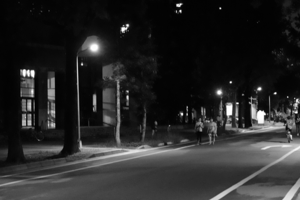
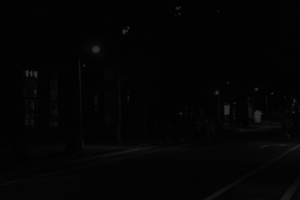


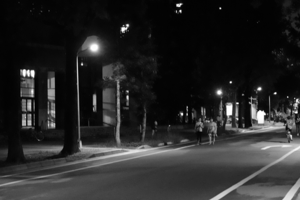
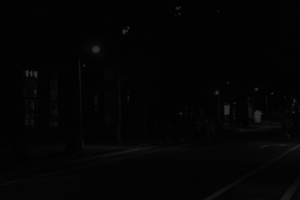

In [25]:
ipyplot.plot_images([jpg, raw],img_width=300,max_images=3)

## Matching histograms

In [26]:
jpg = equalize_hist(jpg)
raw = match_histograms(raw, jpg)


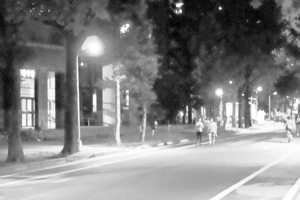
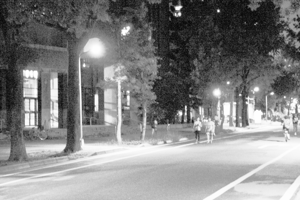


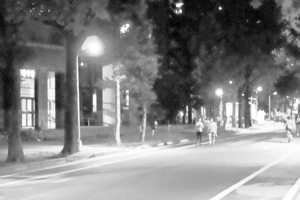
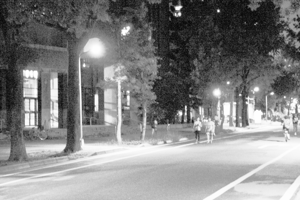

In [27]:
ipyplot.plot_images([jpg, raw],img_width=300,max_images=3)


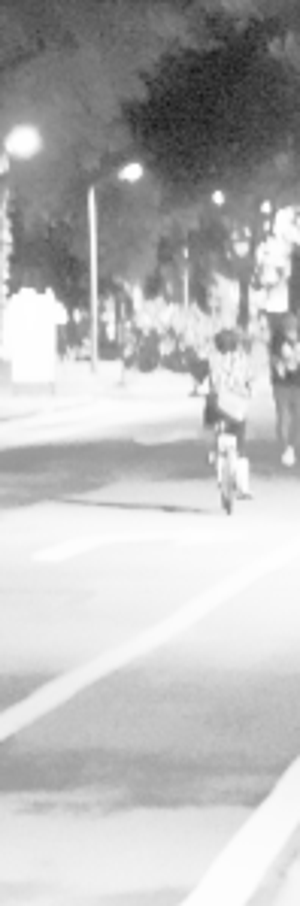
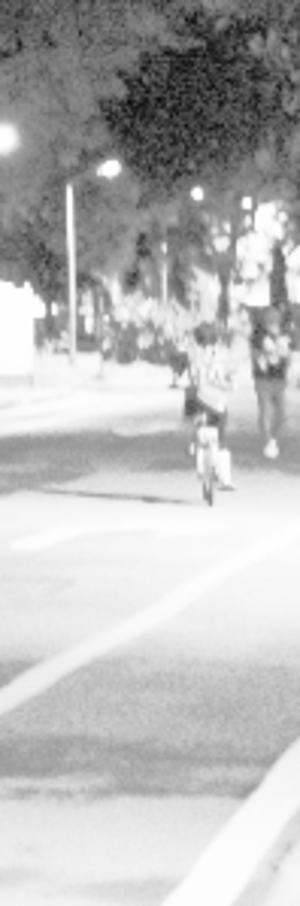


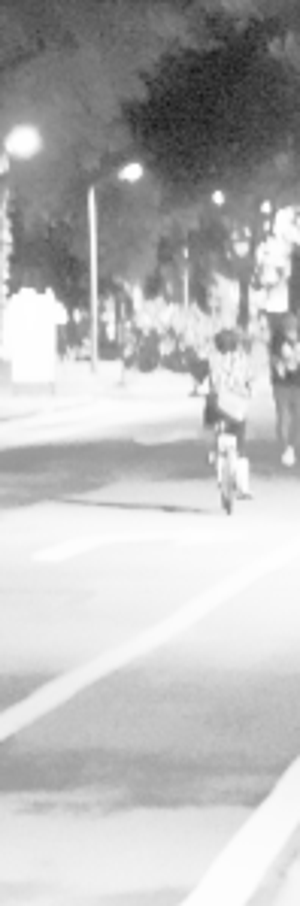
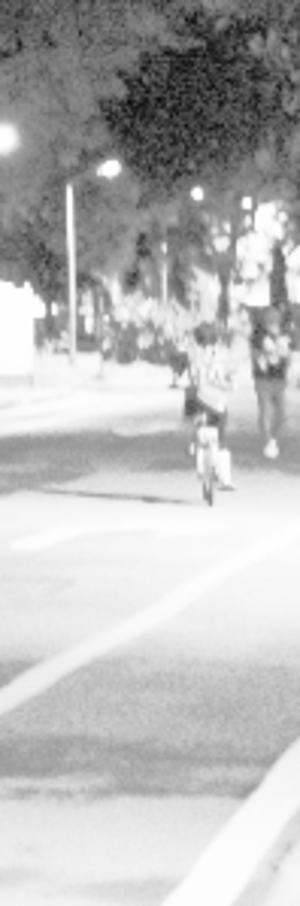

In [28]:
ipyplot.plot_images([jpg[-300:-1, -100:-1], raw[-300:-1, -100:-1]],img_width=300,max_images=3)

## Matching

In [8]:
detector = cv2.xfeatures2d.SIFT_create()
FLANN_INDEX_KDTREE = 1
MIN_MATCH_COUNT  = 10
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
img1 = (jpg * 255).astype(np.uint8)
img2 = (raw * 255).astype(np.uint8)
kp1, des1 = detector.detectAndCompute(img1,None)
kp2, des2 = detector.detectAndCompute(img2,None)
matches = flann.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    S = cv2.estimateRigidTransform(src_pts, dst_pts, True)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
else:
    print("[WARNING] {} ignored, (not enough good matches)")
    H, S, mask = None, None, None
    matchesMask = None

In [9]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)


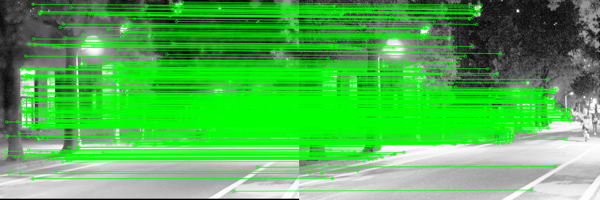


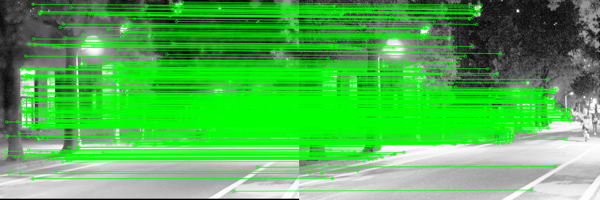

In [10]:
ipyplot.plot_images([img3],img_width=600,max_images=3)

In [11]:
S

array([[ 9.79774768e-01, -3.47074247e-03,  9.29783728e+00],
       [-6.78147063e-04,  9.77480811e-01,  6.87113370e+00]])

In [12]:
H

array([[ 9.83768618e-01, -2.46769119e-03,  8.76185997e+00],
       [ 3.04681890e-03,  9.76285221e-01,  6.51357388e+00],
       [ 1.31205787e-05, -7.14089082e-06,  1.00000000e+00]])

In [13]:
S@np.array([1000, 1000,1])

array([985.6018629 , 983.67379743])

In [14]:
H@np.array([1000, 1000,1])

array([990.06278647, 985.84561427,   1.00597969])

In [15]:
y1,y2,x1,x2 = 2000,3000,2000,3000

In [16]:
X=(s_jpg*np.linalg.inv(H))@np.array([[x1,y1,1],[x2,y2,1]]).T
rx1, ry1 = X.T[0].astype(np.int)
rx2, ry2 = X.T[1].astype(np.int)
print(rx1, rx2, ry1, ry2)
print(X)
jpg = cv2.imread(jpg_fp)
jpg = cv2.cvtColor(jpg, cv2.COLOR_BGR2GRAY)
raw = read_avg_green_raw(raw_fp)

jpg = equalize_hist(jpg)
raw = equalize_hist(raw)

/home/phd/09/igor/miniconda3/envs/mmdet/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


ValueError: too many values to unpack (expected 2)


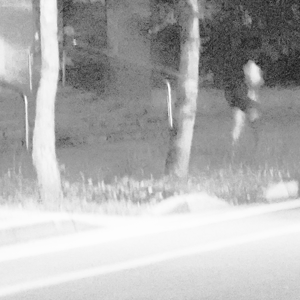
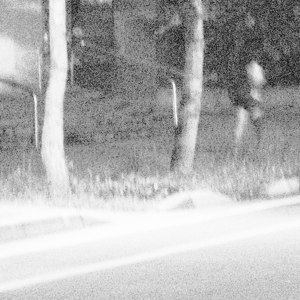


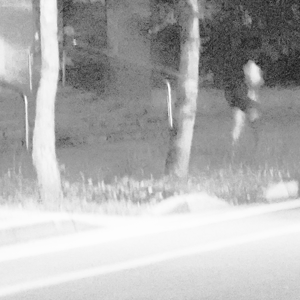
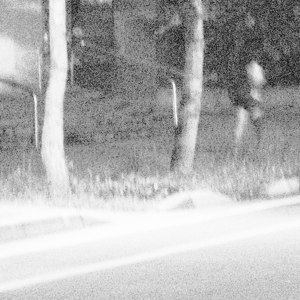

In [52]:
ipyplot.plot_images([jpg[y1:y2, x1:x2], raw[y1//2:y2//2, x1//2:x2//2]],img_width=300,max_images=3)


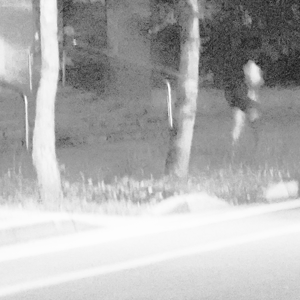
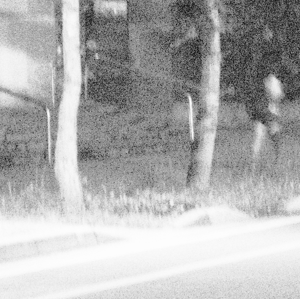


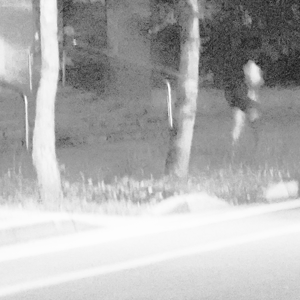
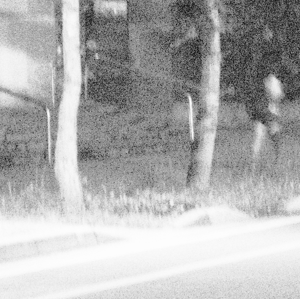

In [53]:
ipyplot.plot_images([jpg[y1:y2, x1:x2], raw[ry1:ry2, rx1:rx2]],img_width=300,max_images=3)

In [58]:
X=(s_jpg*H)@np.array([[x1,y1,1],[x2,y2,1]]).T
X

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)